In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from pathlib import Path

In [3]:
df=pd.read_csv("IRIS.csv")

In [6]:
df.head

<bound method NDFrame.head of      sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]>

In [7]:
df.shape

(150, 5)

In [8]:
print("Class distribution:\n", df["species"].value_counts())


Class distribution:
 species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [9]:
X = df.drop(columns=["species"])
y = df["species"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Label mapping: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

X_train.shape, X_test.shape


((120, 4), (30, 4))

In [11]:
rf = RandomForestClassifier(
    n_estimators=200,  
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Model trained.")


Model trained.


Test Accuracy: 0.9000

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30

Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]


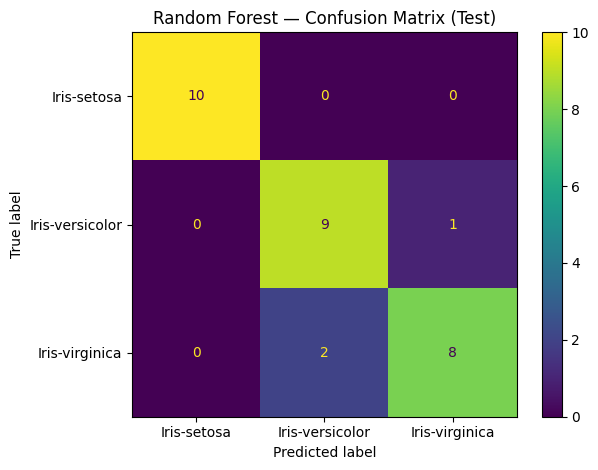

In [13]:
import matplotlib.pyplot as plt
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(values_format="d")
plt.title("Random Forest — Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y_enc, cv=cv, scoring="accuracy", n_jobs=-1)

print("5-fold CV scores:", np.round(cv_scores, 4).tolist())
print(f"CV mean: {cv_scores.mean():.4f} | CV std: {cv_scores.std():.4f}")


5-fold CV scores: [1.0, 0.9667, 0.9333, 1.0, 0.9]
CV mean: 0.9600 | CV std: 0.0389


petal_length    0.453793
petal_width     0.412449
sepal_length    0.115873
sepal_width     0.017885
dtype: float64


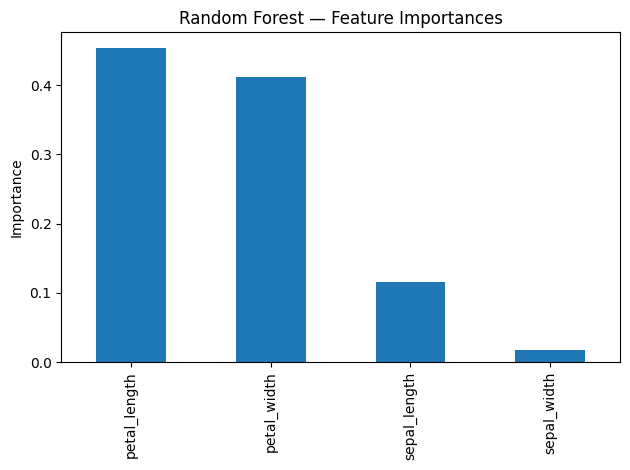

In [15]:
import matplotlib.pyplot as plt
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp)

imp.plot(kind="bar")
plt.title("Random Forest — Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [16]:
out = Path("./artifacts")
out.mkdir(parents=True, exist_ok=True)

joblib.dump(rf, out / "iris_random_forest.joblib")
joblib.dump(le, out / "label_encoder.joblib")

print("Saved:", out / "iris_random_forest.joblib")
print("Saved:", out / "label_encoder.joblib")


Saved: artifacts\iris_random_forest.joblib
Saved: artifacts\label_encoder.joblib


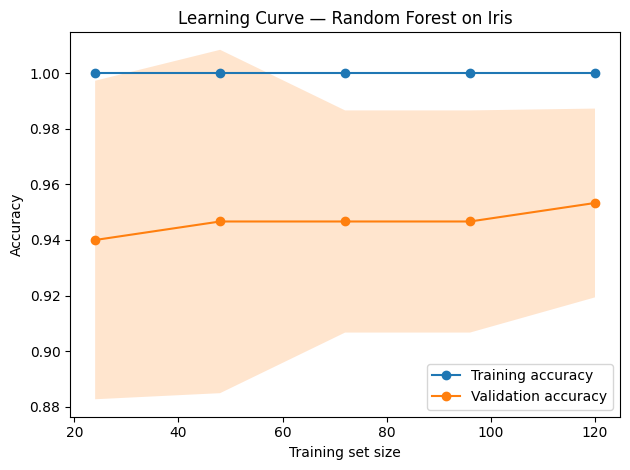

Learning Curve (sizes): [24, 48, 72, 96, 120]
Training accuracy means: [1.0, 1.0, 1.0, 1.0, 1.0]
Validation accuracy means: [0.94, 0.9467, 0.9467, 0.9467, 0.9533]


In [20]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y_enc, cv=cv5, scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=1, shuffle=True, random_state=42
)

train_means = train_scores.mean(axis=1)
val_means   = val_scores.mean(axis=1)
train_stds  = train_scores.std(axis=1)
val_stds    = val_scores.std(axis=1)

plt.plot(train_sizes, train_means, marker="o", label="Training accuracy")
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds, alpha=0.2)
plt.plot(train_sizes, val_means, marker="o", label="Validation accuracy")
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds, alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve — Random Forest on Iris")
plt.legend()
plt.tight_layout()
plt.show()

print("Learning Curve (sizes):", train_sizes.tolist())
print("Training accuracy means:", np.round(train_means, 4).tolist())
print("Validation accuracy means:", np.round(val_means, 4).tolist())


In [21]:
# Format: [sepal_length, sepal_width, petal_length, petal_width]
new_X = pd.DataFrame([
    [5.1, 3.5, 1.4, 0.2],  # likely setosa
    [6.1, 2.8, 4.0, 1.3],  # likely versicolor
    [6.5, 3.0, 5.2, 2.0],  # likely virginica
], columns=X.columns)

pred_ids = rf.predict(new_X)
pred_labels = le.inverse_transform(pred_ids)
pd.DataFrame({"input": list(map(list, new_X.values)), "prediction": pred_labels})


,input,prediction
0,"[5.1, 3.5, 1.4, 0.2]",Iris-setosa
1,"[6.1, 2.8, 4.0, 1.3]",Iris-versicolor
2,"[6.5, 3.0, 5.2, 2.0]",Iris-virginica
